## Welcome to the `SSL deeplabv3+` Workshop!
In this workshop, we'll learn the concept of how to use deeplabv3+ model (involving Atrous convolutions, Atrous Spatial Pyramid Pooling, Decoder) for Semantic Segmentation using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define deeplabv3+ model using resnet50, Atrous convolutions, ASPP modules, Decoder
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

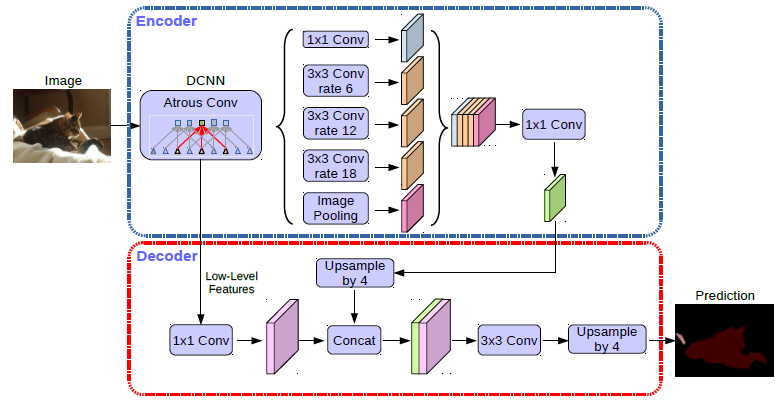

[Image reference](https://arxiv.org/pdf/1802.02611.pdf)

In [1]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b1365b54d3102a4df1dfd9d42fea0e4957a43d1e74bf292d820607d86ace470d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3e34012de6b5916166de718c78895a123fde4a6890de45c9ffd997fa4973b0ad
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built 

# Basic Imports

In [2]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use Cityscapes dataset

In [3]:
dataset_path = '../input/image-segmentation/'
output_path = '.'

# add utils script path 
import sys
sys.path.append(dataset_path)

In [4]:
targetWidth = 1024
targetHeight = 512

In [5]:
# utility functions to get Cityscapes Pytorch dataset and dataloaders
from utils import get_dataloaders
from cityScapes_utils import get_cs_datasets

train_set, val_set, test_set= get_cs_datasets(rootDir='../input/cityscapes-512x1024')
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set, batch_size=4)

There are 2380 train images, 595 validation images, 500 test Images
Input shape = torch.Size([3, 512, 1024]), output label shape = torch.Size([512, 1024])


## Show Sample images from dataset

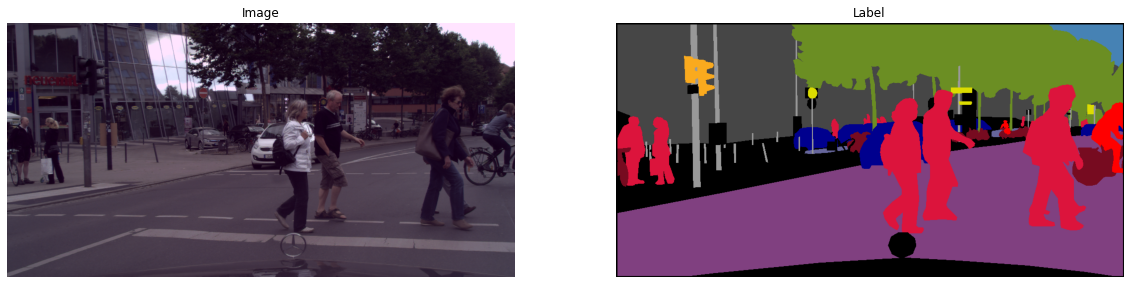

In [6]:
from utils import inverse_transform
from cityScapes_utils import train_id_to_color as cs_train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(cs_train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : 

In [7]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, dilation=dilation_rate, padding=dilation_rate, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        return self.conv(x)

In [8]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

In [9]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])
        
        # skip-connection, match the output channels
        # using 1x1 convolutions
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))
        
        # spatial pyramid pooling wiht atrous convolutions
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))
            
        # image pooling layer
        layers.append(aspp_pool(in_channels, out_channels))
        
        # create Pytorch module list
        self.layers = nn.ModuleList(layers)
        
        # 1x1 convolution to project concatenated output
        # to desired number of channels
        self.project = nn.Sequential(
            nn.Conv2d(len(layers) * out_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        conv_outputs = []
        for mod in self.layers:
            mod_output = mod(x)
            conv_outputs.append(mod_output)
        
        # concatenate output and reduce num_channels
        output = self.project(torch.cat(conv_outputs, dim=1))
        return output

In [10]:
class deeplabv3_decoder(nn.Module):
    def __init__(self, num_classes):
        super(deeplabv3_decoder, self).__init__()
        self.num_classes = num_classes
        
        # resnet low level features contain 256 channels
        self.low_level_project = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU())
        
        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),            
            nn.Conv2d(256, self.num_classes, kernel_size=1))
                     
        
    def forward(self, x, low_level_feat):
        # projected_low_level_feat = (48, h//4, w//4)
        low_level_feat = self.low_level_project(low_level_feat)

        # x = (256, h//4, w//4)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)
        
        # x = (256 + 48, h//4, w//4)
        x = torch.cat((x, low_level_feat), dim=1)
        
        # x = (num_classes, h//4, w//4)
        x = self.cls(x)
        return x

In [11]:
from torchvision.models import resnet50

class deeplabv3_plus(nn.Module):
    def __init__(self, in_channels, output_stride, num_classes):
        super(deeplabv3_plus, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.output_stride = output_stride
        
        if(output_stride == 16):
            dilation_rates = [6, 12, 18]
            replace_stride_with_dilation = [False, False, True]
            
        elif(output_stride == 8):
            dilation_rates = [12, 24, 36]
            replace_stride_with_dilation=[False, True, True]
                
        # backbone layers    
        backbone = resnet50(pretrained=True, replace_stride_with_dilation = replace_stride_with_dilation)        
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # ASPP modules
        aspp_out_channels = 256
        aspp_in_channels = int(backbone.fc.in_features)        
        self.aspp_module = atrous_spatial_pyramid_pooling(aspp_in_channels, 
                       out_channels=aspp_out_channels, dilation_rates=dilation_rates)
        
        # Decoder module
        self.decoder = deeplabv3_decoder(self.num_classes)
                      
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Pass input through Backbone layers
        x = self.initial(x)
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)
                        
        # ASPP and classifier layers
        aspp_output = self.aspp_module(x)
        decoder_output = self.decoder(aspp_output, low_level_feat)
        return F.interpolate(decoder_output, size=input_size, mode='bilinear', align_corners=False)

# 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [12]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

## Model Training

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# MODEL HYPERPARAMETERS
N_EPOCHS = 1
NUM_CLASSES = 19
MAX_LR = 1e-3
MODEL_NAME = f'SSL_deeplabv3_plus_resnet50_os{targetHeight}_{targetWidth}_CE_loss_cityscapes'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
# criterion = smp.losses.DiceLoss('multiclass', classes=np.arange(20).tolist(), log_loss = True, smooth=1.0)
criterion = nn.CrossEntropyLoss(ignore_index=19)

# create model, load imagenet pretrained weights
model = deeplabv3_plus(in_channels=3, output_stride=8, num_classes=NUM_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
pretrained_dict = torch.load('/kaggle/input/simclr_r50/pytorch/dino-r50-pretrained/1/dino_resnet50.pt', map_location=device)

# Load only backbone layers from pretrained model
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
model.load_state_dict(model_dict)

<All keys matched successfully>

In [15]:
# # Freeze layers with pretrained weights
# layers_to_freeze = ['initial', 'layer1', 'layer2', 'layer3', 'layer4']
# for param in model.named_parameters():
#     if(any([param[0].startswith(x) for x in layers_to_freeze])):
#         param[1].requires_grad = False

In [ ]:
# create optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

Starting 1 epoch ...


 44%|████▍     | 262/595 [07:14<09:08,  1.65s/it]

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

In [ ]:
from utils import visualize_predictions
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, 
                      id_to_color = cs_train_id_to_color)

## Test on sample video

In [ ]:
import os
from tqdm import tqdm
from utils import preprocess

def predict_cs_video(model, model_name, demo_video_path, id_to_color,
                     output_dir, target_width, target_height, device,
                    fps : int = 20, alpha : float = 0.3):
    
    test_images = [os.path.join(demo_video_path, *[x]) for x in sorted(os.listdir(demo_video_path))]
    
    output_filename = f'{model_name}_cs_part_overlay_demo_video.avi'
    output_video_path = os.path.join(output_dir, *[output_filename])

    # handles for input output videos
    output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), \
                                    20, (target_width, target_height))

    # create progress bar
    num_frames = int(len(test_images))
    pbar = tqdm(total = num_frames, position=0, leave=True)

    for i in range(num_frames):
        frame = cv2.imread(test_images[i])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # create torch tensor to give as input to model
        pt_image = preprocess(frame)
        pt_image = pt_image.to(device)

        # get model prediction and remap certain labels to showcase 
        # only certain colors. class index 19 has color map (0,0,0), 
        # so remap unwanted classes to 19
        y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
        predicted_labels = y_pred.cpu().detach().numpy()
        predicted_labels[(predicted_labels < 11) & (predicted_labels != 0) & (predicted_labels != 6) & (predicted_labels != 7)] = 19
        
        # convert to corresponding color
        cm_labels = (id_to_color[predicted_labels]).astype(np.uint8)
        
        # overlay prediction over input frame
        overlay_image = cv2.addWeighted(frame, 1, cm_labels, alpha, 0)
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

        # write output result and update progress
        output_handle.write(overlay_image)
        pbar.update(1)

            
    output_handle.release()

In [ ]:
predict_cs_video(model, MODEL_NAME, 
                 demo_video_path = '../input/cityscapes-512x1024/demoVideo/stuttgart_00', 
                 id_to_color = cs_train_id_to_color,
                 output_dir = '.', 
                 target_width = targetWidth, 
                 target_height = targetHeight, 
                 device = device,
                 alpha=0.7)